In [207]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# We need these two classes to set proper ticklabels for Cartopy maps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pyproj
import numpy as np
import verde as vd

In [2]:
data = vd.datasets.fetch_baja_bathymetry()
region = vd.get_region(data.longitude, data.latitude)
print("Data region:", region)

Data region: (245.0, 254.705, 20.0, 29.99131)


In [219]:
%%time
spacing = 10/60
lon, lat, bathymetry = vd.block_reduce(data.longitude, data.latitude,
                                         data.bathymetry_m, 
                                         reduction=np.median, spacing=spacing)
print(bathymetry.size)

1801
CPU times: user 2.72 s, sys: 2.95 ms, total: 2.72 s
Wall time: 2.73 s


In [220]:
outliers = np.random.RandomState(2).randint(low=0, high=bathymetry.size, size=20)
outliers

array([1192,  527,  493, 1608, 1558,  299,  466, 1099,  360, 1287,  674,
        433,  607,  587,  725, 1071,  831, 1311,  730,  404])

In [221]:
bathymetry[outliers] += 5000

In [222]:
weights = np.ones_like(bathymetry)
weights[outliers] = 1e-5

In [223]:
# Project the data using pyproj so that we can use it as input for the gridder.
# We'll set the latitude of true scale to the mean latitude of the data.
projection = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())
coordinates = projection(lon, lat)

In [224]:
%%time
# Now we can set up a gridder for the decimated data
spline = vd.Spline().fit(coordinates, bathymetry)
spline_weights = vd.Spline(damping=1e-8).fit(coordinates, bathymetry, weights)

CPU times: user 11.1 s, sys: 61.5 ms, total: 11.1 s
Wall time: 2.92 s


In [225]:
grids = [sp.grid(region=region, spacing=spacing, projection=projection,
                 dims=['latitude', 'longitude'], data_names=['bathymetry'])
         for sp in [spline, spline_weights]]

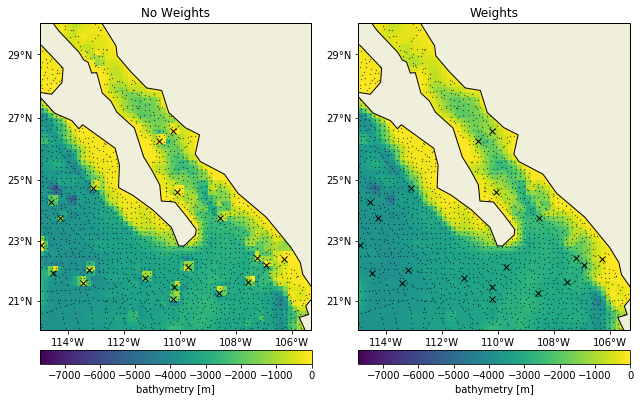

In [228]:
crs = ccrs.PlateCarree()

fig, axes = plt.subplots(1, 2, figsize=(9, 6), subplot_kw=dict(projection=ccrs.Mercator()))
titles = ['No Weights', 'Weights']
for ax, title, grid in zip(axes, titles, grids):
    ax.set_title(title)
    pc = ax.pcolormesh(grid.longitude, grid.latitude, grid.bathymetry,
                       transform=crs, vmax=0, vmin=data.bathymetry_m.min())
    cb = plt.colorbar(pc, ax=ax, orientation='horizontal', pad=0.05)
    cb.set_label('bathymetry [m]')
    ax.add_feature(cfeature.LAND, edgecolor='black', zorder=2)
    # Plot the locations of the decimated data
    ax.plot(lon, lat, '.k', markersize=0.5, transform=crs)
    ax.plot(lon[outliers], lat[outliers], 'xk', transform=crs)
    ax.set_extent(region, crs=crs)
    # Set the proper ticks for a Cartopy map
    ax.set_xticks(np.arange(-114, -105, 2), crs=crs)
    ax.set_yticks(np.arange(21, 30, 2), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

plt.tight_layout()
plt.show()